In [428]:
pip install scikeras[tensorflow]

Note: you may need to restart the kernel to use updated packages.


In [429]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [430]:
bank = pd.read_csv("bank.csv",sep=";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [551]:
# Look for numeric vs categorical data

bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4521 non-null   int64
 1   job        4521 non-null   int64
 2   marital    4521 non-null   int64
 3   education  4521 non-null   int64
 4   default    4521 non-null   int64
 5   balance    4521 non-null   int64
 6   housing    4521 non-null   int64
 7   loan       4521 non-null   int64
 8   contact    4521 non-null   int64
 9   day        4521 non-null   int64
 10  month      4521 non-null   int64
 11  campaign   4521 non-null   int64
 12  pdays      4521 non-null   int64
 13  previous   4521 non-null   int64
 14  poutcome   4521 non-null   int64
 15  y          4521 non-null   int64
dtypes: int64(16)
memory usage: 565.3 KB


In [432]:
missing_values = bank.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [433]:
bank.shape

(4521, 17)

In [434]:
missing_values = bank.isna().sum()
print(missing_values)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


## Find Categorical data

In [435]:
bk=bank.select_dtypes(include="object")
for x in bk.columns:
    print(x+"   ",bk[x].unique())

job    ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
marital    ['married' 'single' 'divorced']
education    ['primary' 'secondary' 'tertiary' 'unknown']
default    ['no' 'yes']
housing    ['no' 'yes']
loan    ['no' 'yes']
contact    ['cellular' 'unknown' 'telephone']
month    ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
poutcome    ['unknown' 'failure' 'other' 'success']
y    ['no' 'yes']


In [436]:
# UCI site states this column should be removed for prediction purposes

bank = bank.drop(columns=['duration'])

In [437]:
# Select numeric columns
bk_numer=bank.select_dtypes(include="int")

In [438]:
bk_numer.head()

,age,balance,day,campaign,pdays,previous
0,30,1787,19,1,-1,0
1,33,4789,11,1,339,4
2,35,1350,16,1,330,1
3,30,1476,3,4,-1,0
4,59,0,5,1,-1,0


# HotEncode Categorical to numerical

In [440]:
job_map = {'unemployed':0, 'services':1, 'management':2, 'blue-collar':3, 'self-employed':4,
 'technician':5, 'entrepreneur':6, 'admin.':7, 'student':8, 'housemaid':9, 'retired':10,
 'unknown':11}

In [441]:
marital_map= {'married':0, 'single':1, 'divorced':2}

In [442]:
education_map = {'primary':0, 'secondary':1, 'tertiary':2, 'unknown':3}

In [443]:
default_map = {'no':0,'yes':1}

In [444]:
housing_map = {'no':0,'yes':1}

In [445]:
loan_map = {'no':0,'yes':1}

In [446]:
contact_map = {'cellular':0, 'unknown':1, 'telephone':2}

In [447]:
month_map = {'jan':0, 'feb':1, 'mar':2, 'apr':3, 'may':4,  'jun':5, 'jul':6, 'aug':7, 'sep':8,  'oct':9, 'nov':10, 'dec':11}

In [448]:
poutcome_map= {'unknown':0, 'failure':1, 'other':2, 'success':3}

In [449]:
y_map = {'no':0,'yes':1}

In [450]:
bank['job'] = bank['job'].map(job_map)

In [451]:
bank['marital'] = bank['marital'].map(marital_map)

In [452]:
bank['education'] = bank['education'].map(education_map)

In [453]:
bank['default'] = bank['default'].map(default_map)

In [454]:
bank['housing'] = bank['housing'].map(housing_map)

In [455]:
bank['loan'] = bank['loan'].map(loan_map)

In [456]:
bank['contact'] = bank['contact'].map(contact_map)
bank['month'] = bank['month'].map(month_map)
bank['poutcome'] = bank['poutcome'].map(poutcome_map)
bank['y'] = bank['y'].map(y_map)

In [457]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,30,0,0,0,0,1787,0,0,0,19,9,1,-1,0,0,0
1,33,1,0,1,0,4789,1,1,0,11,4,1,339,4,1,0
2,35,2,1,2,0,1350,1,0,0,16,3,1,330,1,1,0
3,30,2,0,2,0,1476,1,1,1,3,5,4,-1,0,0,0
4,59,3,0,1,0,0,1,0,1,5,4,1,-1,0,0,0


In [555]:
# List of categorical data

cat_list=list(bk.columns)
cat_list.pop()
print(cat_list)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [460]:
# Hot encoding of categorical data

bank_hotencoded = pd.get_dummies(bank,columns=cat_list,dtype=int)

In [461]:
bank_hotencoded.head()

,age,balance,day,campaign,pdays,previous,y,job_0,job_1,job_2,...,month_6,month_7,month_8,month_9,month_10,month_11,poutcome_0,poutcome_1,poutcome_2,poutcome_3
0,30,1787,19,1,-1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1,33,4789,11,1,339,4,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,35,1350,16,1,330,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,30,1476,3,4,-1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,59,0,5,1,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


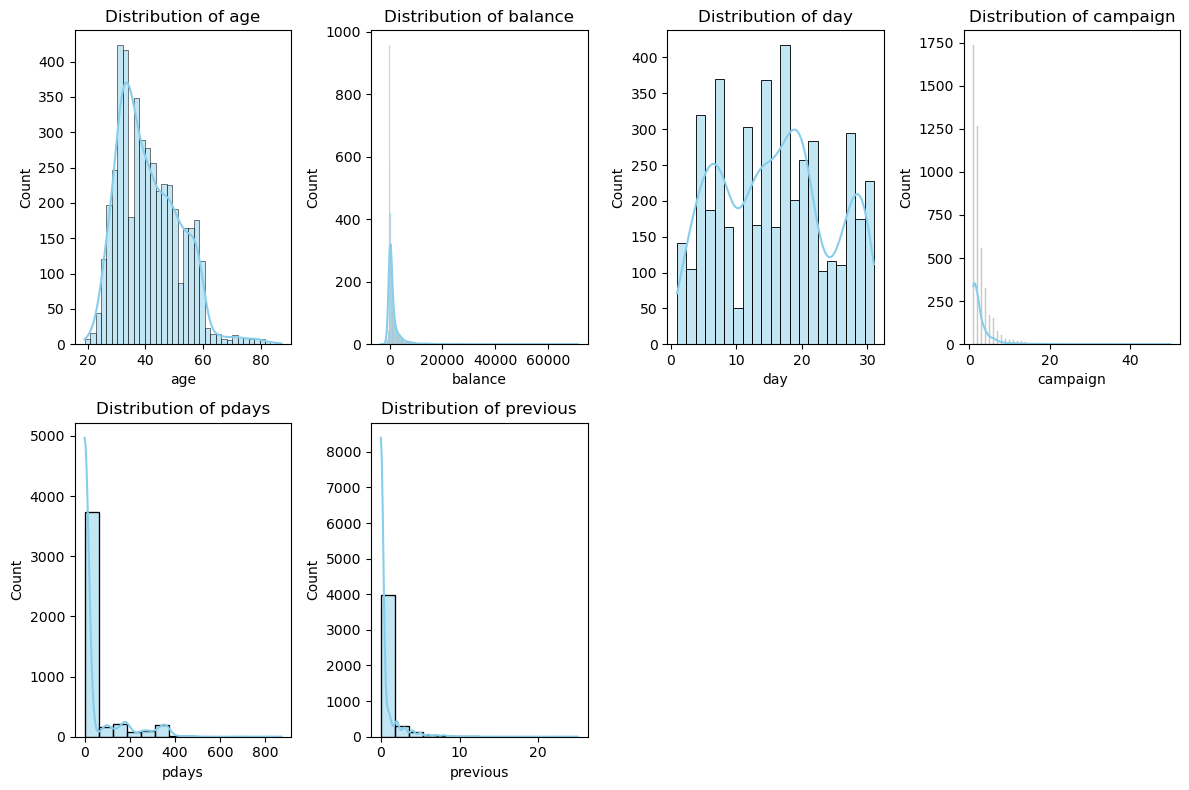

In [462]:
# Visualize distribution of numerical features (excluding the target variable)
features = bk_numer

# Adjust grid size for the number of features
n_features = len(features.columns)
n_cols = 4  # Number of columns
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)  # Dynamic number of rows

plt.figure(figsize=(12, n_rows * 4))
for i, feature in enumerate(features.columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Create a grid of subplots dynamically
    sns.histplot(features[feature], kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [547]:
import seaborn as sns
import matplotlib.pyplot as plt


# Detect outliers using IQR for each numerical feature
Q1 = bk_numer.quantile(0.25)
Q3 = bk_numer.quantile(0.75)
IQR = Q3 - Q1

# Define outliers (values outside 1.5 * IQR from Q1 and Q3)
outliers = ((bk_numer < (Q1 - 1.5 * IQR)) | 
            (bk_numer > (Q3 + 1.5 * IQR)))
outlier_count = outliers.sum()

# Print the number of outliers in each feature
print("Number of outliers in each feature:")
print(outlier_count)



Number of outliers in each feature:
age          38
balance     506
day           0
campaign    318
pdays       816
previous    816
dtype: int64


# Check for Imbalanced Data

C:\Users\Windows\AppData\Local\Temp\ipykernel_14200\4237154604.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')


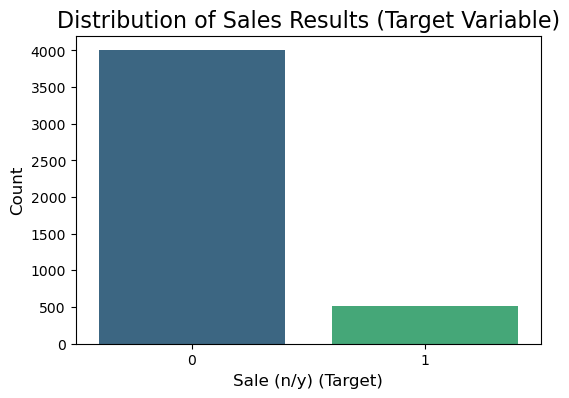

In [395]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each target value
target_counts = bank['y'].value_counts()

# Plot a bar chart using matplotlib
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Sales Results (Target Variable)', fontsize=16)
plt.xlabel('Sale (n/y) (Target)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=range(len(target_counts.index)), labels=target_counts.index, rotation=0)

# Display the plot
plt.show()

In [398]:
# Split features and target variable
X = bank_hotencoded.drop('y', axis=1)
y = bank_hotencoded['y']

In [400]:
X.shape,y.shape

((4521, 50), (4521,))

In [402]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3616, 50), (905, 50), (3616,), (905,))

In [536]:
print(pd.Series(y_test).value_counts())

y
0    807
1     98
Name: count, dtype: int64


In [404]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [406]:
print("Class distribution in the resampled training set:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution in the resampled training set:
y
0    3193
1    3193
Name: count, dtype: int64


# Implement RandomTree Classifier


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#def run_model(test_split):

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 20)
    #Standardize features by removing the mean and scaling to unit variance

rf = RandomForestClassifier()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100,200],
    'max_depth':[5,10,20],
    'min_samples_leaf':[2,3,4],
    'criterion' :['gini','entropy']
     
}

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0)
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)


# mse_RF = mean_squared_error(y_test, y_pred)
# mae_RF = mean_absolute_error(y_test, y_pred)
# R2 = r2_score(y_test,y_pred_RF)
# print('Mean squared error using Random Forest: ', mse_RF)
# print('Mean absolute error Using Random Forest: ', mae_RF)
# print('R2 Score: ' , R2)

#Feature ranking...
import pandas as pd
feature_list = list(X.columns)
feature_imp = pd.Series(best_model.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp)



splits = [0.2,0.25, 0.3]

# for split in splits:
#     run_model(split)

In [ ]:

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix with appropriate labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['True Benign 0', 'True Malignan 1'])



# Add labels and title to the plot
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))